In [1]:
# importing necessary libraries

import numpy as np
import yfinance as yf # This library is for fetching stock data from yahoo finance
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Fetch historical stock data using yfinance
stock_symbol = 'AMZN'
start_date = '2012-01-01'
end_date = '2023-01-01'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,8.794500,8.974000,8.777500,8.951500,8.951500,102216000
2012-01-04,8.960500,9.025000,8.803500,8.875500,8.875500,84104000
2012-01-05,8.797000,8.912500,8.702500,8.880500,8.880500,76182000
2012-01-06,8.903500,9.232500,8.875000,9.130500,9.130500,140168000
2012-01-09,9.138000,9.218500,8.850000,8.928000,8.928000,101138000
...,...,...,...,...,...,...
2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000
2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600


In [5]:
# Extract adjusted closing prices
prices = stock_data['Adj Close'].values
print(prices)

[ 8.95149994  8.87549973  8.88049984 ... 81.81999969 84.18000031
 84.        ]


In [6]:
# Calculate RSI indicator
rsi_period = 14
delta = np.diff(prices)
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
average_gain = np.mean(gain[:rsi_period])
average_loss = np.mean(loss[:rsi_period])
rsi_values = np.zeros_like(prices)
rsi_values[:rsi_period] = 100.0 - (100.0 / (1.0 + (average_gain / average_loss)))

for i in range(rsi_period, len(prices)):
    average_gain = (average_gain * (rsi_period - 1) + gain[i - 1]) / rsi_period
    average_loss = (average_loss * (rsi_period - 1) + loss[i - 1]) / rsi_period
    rsi_values[i] = 100.0 - (100.0 / (1.0 + (average_gain / average_loss)))

In [7]:
# Calculate EMA indicators
emaf_period = 12
emaf_values = np.convolve(prices, np.ones(emaf_period)/emaf_period, mode='valid')
emam_period = 26
emam_values = np.convolve(prices, np.ones(emam_period)/emam_period, mode='valid')
emas_period = 50
emas_values = np.convolve(prices, np.ones(emas_period)/emas_period, mode='valid')

In [8]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))
rsi_scaled = scaler.fit_transform(rsi_values.reshape(-1, 1))
emaf_scaled = scaler.fit_transform(emaf_values.reshape(-1, 1))
emam_scaled = scaler.fit_transform(emam_values.reshape(-1, 1))
emas_scaled = scaler.fit_transform(emas_values.reshape(-1, 1))

In [9]:
# Ensure that all indicator arrays have the same length
common_length = min(len(prices_scaled), len(rsi_scaled), len(emaf_scaled), len(emam_scaled), len(emas_scaled))
prices_scaled = prices_scaled[:common_length]
rsi_scaled = rsi_scaled[:common_length]
emaf_scaled = emaf_scaled[:common_length]
emam_scaled = emam_scaled[:common_length]
emas_scaled = emas_scaled[:common_length]

In [10]:
# Create sequences and labels
sequence_length = 30
X = np.column_stack((prices_scaled, rsi_scaled, emaf_scaled, emam_scaled, emas_scaled))
y = prices_scaled[sequence_length:]
X = [X[i:i + sequence_length] for i in range(len(X) - sequence_length)]
y = [y[i + sequence_length] for i in range(len(y) - sequence_length)]

X = np.array(X)
y = np.array(y)

In [11]:
# Ensure that X and y have the same length
common_length = min(len(X), len(y))
X = X[:common_length]
y = y[:common_length]

In [12]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# LSTM_Model Training
# Input layer
Input = layers.Input(shape=(sequence_length,5), name='Input')

# Bidirectional LSTM layer
lstm_1 =layers.Bidirectional(layers.LSTM(100, activation= 'tanh',return_sequences= True,name='first_layer'))(Input)
dropout_1 = layers.Dropout(0.1,name= 'drop_1')(lstm_1)

#LSTM layer
lstm_2= layers.LSTM(100, activation= 'linear', name= 'second_layer')(dropout_1)
dropout_2 = layers.Dropout(0.1,name= 'drop_2')(lstm_2)
dense_1 = layers.Dense(10, activation= 'relu', name='dense_layer')(dropout_2)

#Output layer
Output = layers.Dense(1, activation= 'relu', name='output')(dense_1)
lstm_model = models.Model(inputs=Input, outputs=Output, name= 'LSTM_Model')
lstm_model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 30, 5)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 30, 200)          84800     
 l)                                                              
                                                                 
 drop_1 (Dropout)            (None, 30, 200)           0         
                                                                 
 second_layer (LSTM)         (None, 100)               120400    
                                                                 
 drop_2 (Dropout)            (None, 100)               0         
                                                                 
 dense_layer (Dense)         (None, 10)                1010      
                                                        

In [14]:
# Training the model using appropriate settings
lstm_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
                   loss= 'mean_squared_error',
                   metrics= ['mse', 'mae'])

history = lstm_model.fit(x=X_train, y=y_train,
                         batch_size=32, epochs=50, validation_data=(X_test, y_test),
                         shuffle=True, validation_split = 0.1)

print(history.history.keys)

Epoch 1/50
59/59 [==============================] - 24s 143ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0588 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0384
Epoch 2/50
59/59 [==============================] - 7s 120ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0311 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0234
Epoch 3/50
59/59 [==============================] - 5s 93ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0294 - val_loss: 8.1092e-04 - val_mse: 8.1092e-04 - val_mae: 0.0179
Epoch 4/50
59/59 [==============================] - 4s 68ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0280 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0220
Epoch 5/50
59/59 [==============================] - 7s 114ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0236 - val_loss: 8.1415e-04 - val_mse: 8.1415e-04 - val_mae: 0.0181
Epoch 6/50
59/59 [==============================] - 6s 96ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0209 - val_loss: 4.1776e-04 - val_mse: 4.1776e-04 - val_mae: 0

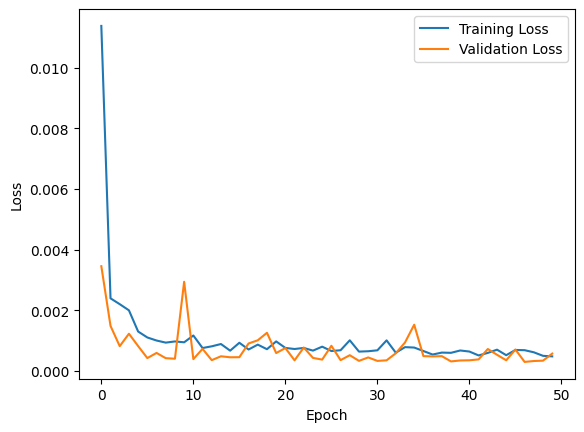

In [15]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Evaluate the model
loss = lstm_model.evaluate(X_test, y_test, verbose=0)[0]  # Extract the loss value from the list
y_pred = lstm_model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))  # Calculate MAE manually

print(f"Test loss: {loss:.4f}, Test MAE: {mae:.4f}")

25/25 [==============================] - 1s 7ms/step
Test loss: 0.0006, Test MAE: 0.0145


In [17]:
# Prediction on test set
y_pred = lstm_model.predict(X_test)

25/25 [==============================] - 0s 7ms/step


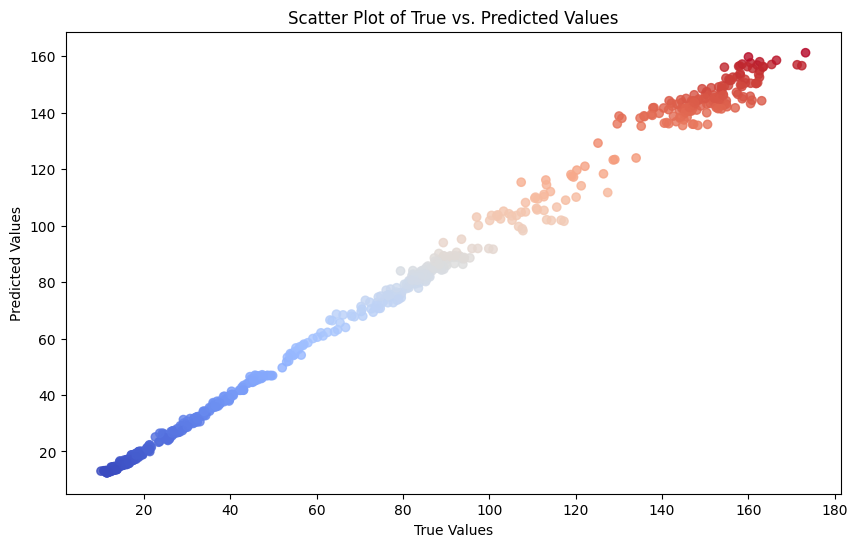

In [18]:
# Inverse scale the predictions and true values
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original,c= y_pred_original, cmap= 'coolwarm', alpha=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()

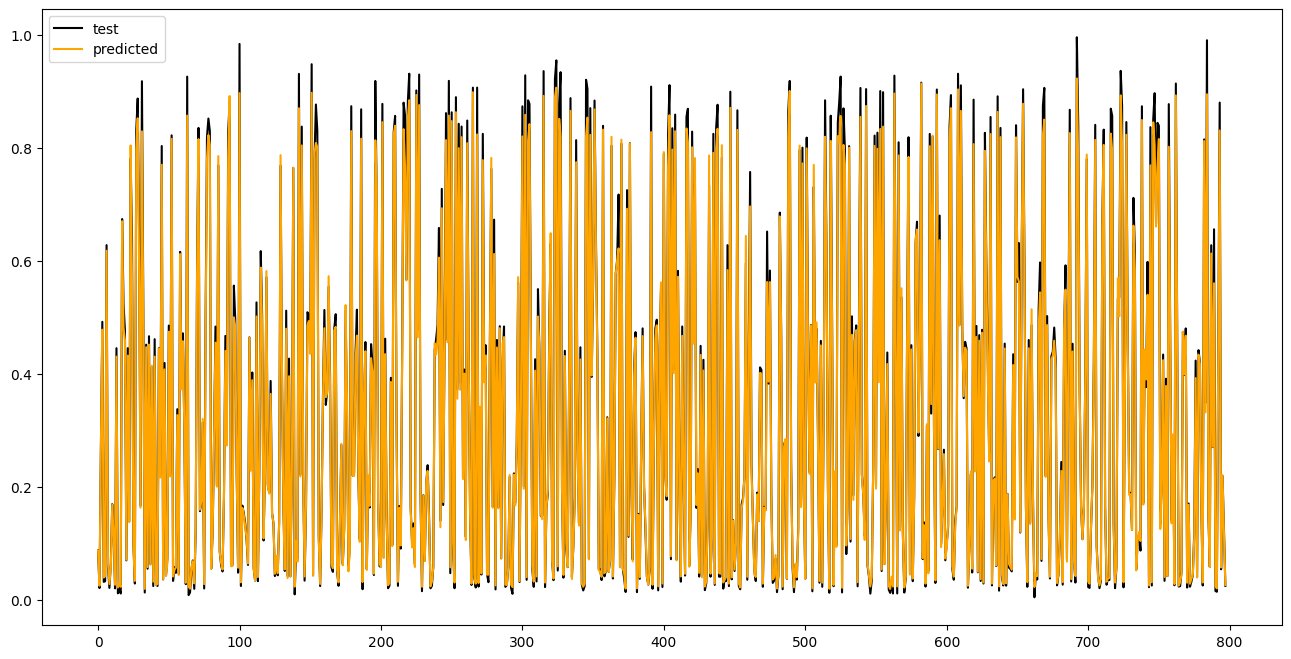

In [19]:
# Line plot for prediction

plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black',label='test')
plt.plot(y_pred, color = 'orange',label='predicted')
plt.legend()
plt.show()

In [20]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0145
Mean Squared Error (MSE): 0.0006
Root Mean Squared Error (RMSE): 0.0238
R-squared (R2) score: 0.9940


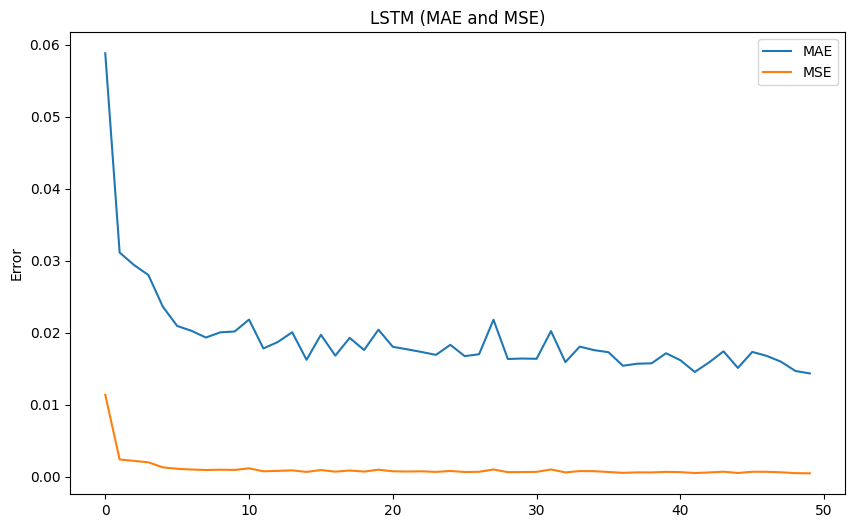

In [21]:
# Line plot over epochs for MAE, MSE

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['mse'], label='MSE')
plt.ylabel('Error')
plt.title('LSTM (MAE and MSE)')
plt.legend()
plt.show()